<a href="https://colab.research.google.com/github/lin3372/600_graph_neural_net/blob/main/stanford_cs224w/cs224w_07_graph_neural_networks_2_design_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/mnslarcher/cs224w-slides-to-code/blob/main/notebooks/07-graph-neural-networks-2-design-space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # Check if PyTorch Geometric is installed:
    import torch_geometric
except ImportError:
    # If PyTorch Geometric is not installed, install it.
    %pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-geometric

     |████████████████████████████████| 43 kB 880 kB/s 
     |████████████████████████████████| 370 kB 5.5 MB/s 
     |████████████████████████████████| 482 kB 37.4 MB/s 
     |████████████████████████████████| 41 kB 528 kB/s 


# Graph Neural Networks 2: Design Space

In [2]:
import copy
from typing import Callable, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch_geometric.transforms as T
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Sequential
from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
data = dataset[0].to(device)

Processing...
Done!


In [4]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]


def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    acc = accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    acc = accuracy(preds, y)
    return loss.item(), acc

In [5]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]


def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    min_loss = float("inf")
    early_stopping_counter = 0
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # Early stopping
        if val_loss < min_loss:
            min_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter == early_stopping:
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history

In [6]:
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [7]:
# Hyper parameters that we will not change during the experiments:
SEED = 42
HIDDEN_CHANNELS = 16
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4


torch.manual_seed(SEED)

# Classical GNN Layers: GCN

In [8]:
from torch_geometric.nn import GCN


Epoch: 0
----------
Train loss: 2.7734 | Train acc: 0.0357
  Val loss: 2.7648 |   Val acc: 0.2460

Epoch: 20
----------
Train loss: 2.5632 | Train acc: 0.8429
  Val loss: 2.6157 |   Val acc: 0.5860

Epoch: 40
----------
Train loss: 2.4065 | Train acc: 0.8429
  Val loss: 2.5039 |   Val acc: 0.5860

Epoch: 60
----------
Train loss: 2.2918 | Train acc: 0.8357
  Val loss: 2.4212 |   Val acc: 0.5860

Epoch: 80
----------
Train loss: 2.2052 | Train acc: 0.8357
  Val loss: 2.3581 |   Val acc: 0.5940

Epoch: 100
----------
Train loss: 2.1385 | Train acc: 0.8357
  Val loss: 2.3090 |   Val acc: 0.5980

Epoch: 120
----------
Train loss: 2.0863 | Train acc: 0.8286
  Val loss: 2.2701 |   Val acc: 0.6020

Epoch: 140
----------
Train loss: 2.0451 | Train acc: 0.8286
  Val loss: 2.2391 |   Val acc: 0.6100

Epoch: 160
----------
Train loss: 2.0122 | Train acc: 0.8286
  Val loss: 2.2141 |   Val acc: 0.6140

Epoch: 180
----------
Train loss: 1.9858 | Train acc: 0.8286
  Val loss: 2.1938 |   Val acc: 0.6

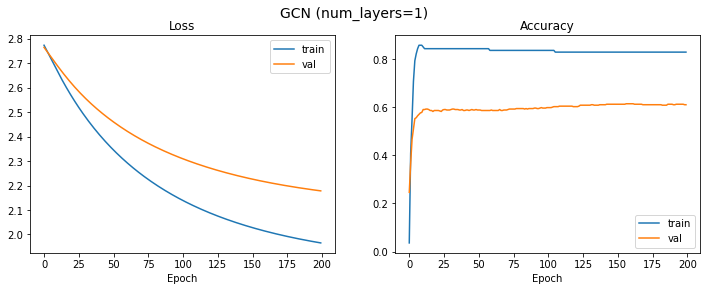

In [9]:
NUM_LAYERS = 1


model = GCN(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCN (num_layers={NUM_LAYERS})")

# Classical GNN Layers: GraphSAGE

In [10]:
from torch_geometric.nn import GraphSAGE


Epoch: 0
----------
Train loss: 2.7760 | Train acc: 0.0000
  Val loss: 2.7701 |   Val acc: 0.1300

Epoch: 20
----------
Train loss: 2.5335 | Train acc: 0.5714
  Val loss: 2.6785 |   Val acc: 0.3340

Epoch: 40
----------
Train loss: 2.3501 | Train acc: 0.5714
  Val loss: 2.6125 |   Val acc: 0.3460

Epoch: 60
----------
Train loss: 2.2246 | Train acc: 0.5714
  Val loss: 2.5704 |   Val acc: 0.3440

Epoch: 80
----------
Train loss: 2.1413 | Train acc: 0.5714
  Val loss: 2.5433 |   Val acc: 0.3460

Epoch: 100
----------
Train loss: 2.0858 | Train acc: 0.5714
  Val loss: 2.5258 |   Val acc: 0.3500

Epoch: 120
----------
Train loss: 2.0480 | Train acc: 0.5714
  Val loss: 2.5143 |   Val acc: 0.3480

Epoch: 140
----------
Train loss: 2.0215 | Train acc: 0.5714
  Val loss: 2.5066 |   Val acc: 0.3440

Epoch: 160
----------
Train loss: 2.0023 | Train acc: 0.5714
  Val loss: 2.5013 |   Val acc: 0.3420

Epoch: 180
----------
Train loss: 1.8680 | Train acc: 0.6214
  Val loss: 2.2890 |   Val acc: 0.3

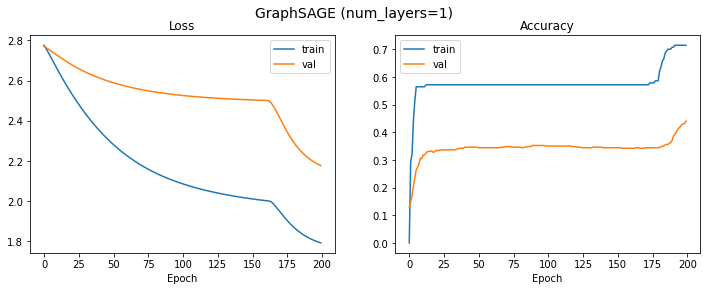

In [11]:
NUM_LAYERS = 1


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS})")

# GraphSAGE Neighbor Aggregation


Epoch: 0
----------
Train loss: 2.7781 | Train acc: 0.0286
  Val loss: 2.7608 |   Val acc: 0.1880

Epoch: 20
----------
Train loss: 2.2491 | Train acc: 0.5643
  Val loss: 2.5276 |   Val acc: 0.4040

Epoch: 40
----------
Train loss: 1.9369 | Train acc: 0.5714
  Val loss: 2.3816 |   Val acc: 0.4380

Epoch: 60
----------
Train loss: 1.7768 | Train acc: 0.5714
  Val loss: 2.3034 |   Val acc: 0.4420

Epoch: 80
----------
Train loss: 1.6925 | Train acc: 0.5714
  Val loss: 2.2579 |   Val acc: 0.4420

Epoch: 100
----------
Train loss: 1.6431 | Train acc: 0.5714
  Val loss: 2.2281 |   Val acc: 0.4400

Epoch: 120
----------
Train loss: 1.6108 | Train acc: 0.5714
  Val loss: 2.2068 |   Val acc: 0.4380

Epoch: 140
----------
Train loss: 1.4038 | Train acc: 0.7143
  Val loss: 2.1716 |   Val acc: 0.4560

Epoch: 160
----------
Train loss: 1.3000 | Train acc: 0.7143
  Val loss: 2.1452 |   Val acc: 0.4640

Epoch: 180
----------
Train loss: 1.2663 | Train acc: 0.7143
  Val loss: 2.1288 |   Val acc: 0.4

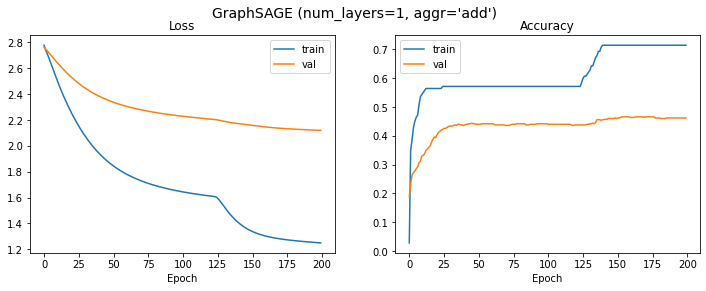

In [12]:
NUM_LAYERS = 1
AGGR = "add"


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, aggr=AGGR).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, aggr='{AGGR}')")

# GraphSAGE: L2 Normalization


Epoch: 0
----------
Train loss: 2.7578 | Train acc: 0.1143
  Val loss: 2.6967 |   Val acc: 0.1580

Epoch: 20
----------
Train loss: 2.3800 | Train acc: 0.5500
  Val loss: 2.5589 |   Val acc: 0.3680

Epoch: 40
----------
Train loss: 2.2793 | Train acc: 0.6357
  Val loss: 2.5209 |   Val acc: 0.4000

Early stopping...

Epoch: 53
----------
Train loss: 2.2568 | Train acc: 0.7143
  Val loss: 2.5264 |   Val acc: 0.3860
 Test loss: 2.5265 |  Test acc: 0.3800


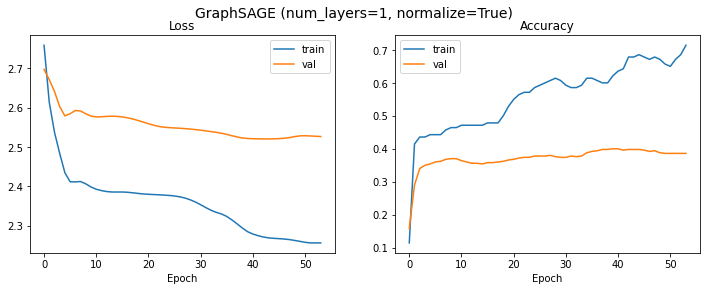

In [13]:
NUM_LAYERS = 1
NORMALIZE = True


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, normalize=NORMALIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, normalize={NORMALIZE})")

# Classical GNN Layers: GAT

In [14]:
from torch_geometric.nn import GAT


Epoch: 0
----------
Train loss: 2.7731 | Train acc: 0.0214
  Val loss: 2.7628 |   Val acc: 0.3200

Epoch: 20
----------
Train loss: 2.5298 | Train acc: 0.9857
  Val loss: 2.5748 |   Val acc: 0.7460

Epoch: 40
----------
Train loss: 2.3352 | Train acc: 0.9929
  Val loss: 2.4266 |   Val acc: 0.7460

Epoch: 60
----------
Train loss: 2.1708 | Train acc: 0.9857
  Val loss: 2.3028 |   Val acc: 0.7180

Epoch: 80
----------
Train loss: 1.9857 | Train acc: 0.9643
  Val loss: 2.1856 |   Val acc: 0.6760

Epoch: 100
----------
Train loss: 1.8027 | Train acc: 0.9643
  Val loss: 2.0851 |   Val acc: 0.6200

Epoch: 120
----------
Train loss: 1.6338 | Train acc: 0.9714
  Val loss: 2.0044 |   Val acc: 0.5760

Epoch: 140
----------
Train loss: 1.4905 | Train acc: 0.9714
  Val loss: 1.9413 |   Val acc: 0.5440

Epoch: 160
----------
Train loss: 1.3796 | Train acc: 0.9714
  Val loss: 1.8878 |   Val acc: 0.5340

Epoch: 180
----------
Train loss: 1.2971 | Train acc: 0.9714
  Val loss: 1.8455 |   Val acc: 0.5

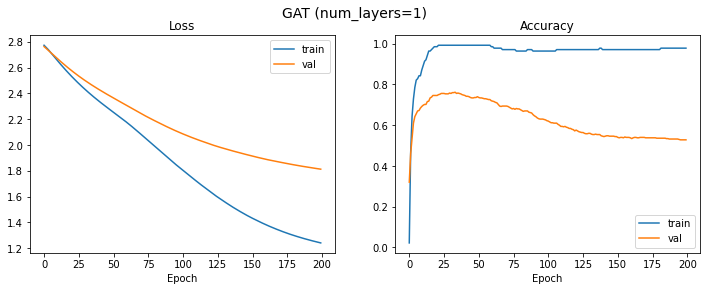

In [15]:
NUM_LAYERS = 1


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS})")

# Attention Mechanism

## Multi-head attention


Epoch: 0
----------
Train loss: 2.7726 | Train acc: 0.0929
  Val loss: 2.7660 |   Val acc: 0.2380

Epoch: 20
----------
Train loss: 2.5353 | Train acc: 0.9786
  Val loss: 2.5797 |   Val acc: 0.7220

Epoch: 40
----------
Train loss: 2.3403 | Train acc: 0.9929
  Val loss: 2.4308 |   Val acc: 0.7520

Epoch: 60
----------
Train loss: 2.1900 | Train acc: 0.9929
  Val loss: 2.3163 |   Val acc: 0.7540

Epoch: 80
----------
Train loss: 2.0507 | Train acc: 0.9929
  Val loss: 2.2170 |   Val acc: 0.7420

Epoch: 100
----------
Train loss: 1.8851 | Train acc: 0.9857
  Val loss: 2.1065 |   Val acc: 0.6960

Epoch: 120
----------
Train loss: 1.7229 | Train acc: 0.9714
  Val loss: 2.0147 |   Val acc: 0.6720

Epoch: 140
----------
Train loss: 1.5796 | Train acc: 0.9714
  Val loss: 1.9422 |   Val acc: 0.6400

Epoch: 160
----------
Train loss: 1.4542 | Train acc: 0.9786
  Val loss: 1.8820 |   Val acc: 0.6100

Epoch: 180
----------
Train loss: 1.3444 | Train acc: 0.9786
  Val loss: 1.8352 |   Val acc: 0.5

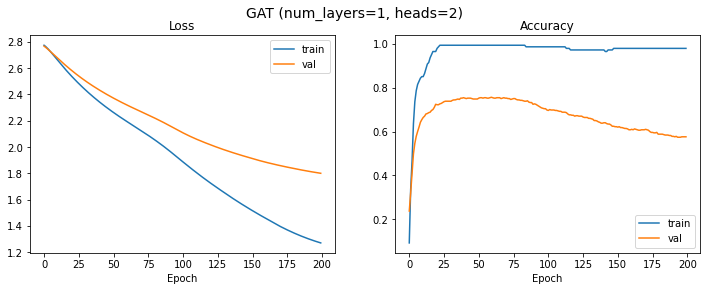

In [16]:
NUM_LAYERS = 1
HEADS = 2


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, heads=HEADS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, heads={HEADS})")

# GNN Layer in Practice

## Batch Normalization

In [17]:
from torch_geometric.nn import BatchNorm


Epoch: 0
----------
Train loss: 2.9728 | Train acc: 0.0286
  Val loss: 2.7692 |   Val acc: 0.1840

Epoch: 20
----------
Train loss: 0.2078 | Train acc: 0.9571
  Val loss: 2.6292 |   Val acc: 0.5600

Epoch: 40
----------
Train loss: 0.1450 | Train acc: 0.9643
  Val loss: 2.4798 |   Val acc: 0.5000

Epoch: 60
----------
Train loss: 0.0595 | Train acc: 0.9857
  Val loss: 2.1763 |   Val acc: 0.5340

Epoch: 80
----------
Train loss: 0.0515 | Train acc: 0.9857
  Val loss: 1.8856 |   Val acc: 0.5180

Epoch: 100
----------
Train loss: 0.0486 | Train acc: 0.9857
  Val loss: 1.8224 |   Val acc: 0.5140

Early stopping...

Epoch: 111
----------
Train loss: 0.0477 | Train acc: 0.9857
  Val loss: 1.8290 |   Val acc: 0.5100
 Test loss: 1.8283 |  Test acc: 0.5180


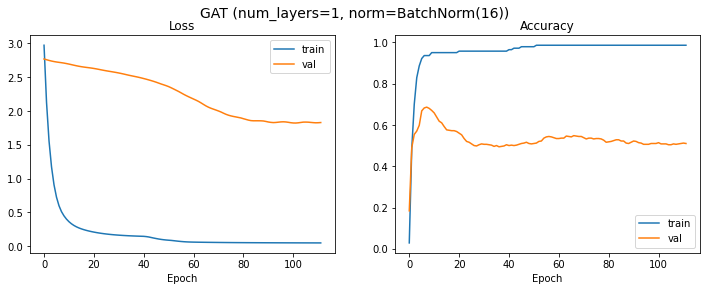

In [18]:
NUM_LAYERS = 1
NORM = BatchNorm(HIDDEN_CHANNELS)


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, norm=NORM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, norm={NORM})")

## Dropout


Epoch: 0
----------
Train loss: 2.7720 | Train acc: 0.1143
  Val loss: 2.7661 |   Val acc: 0.2560

Epoch: 20
----------
Train loss: 2.5636 | Train acc: 0.4929
  Val loss: 2.6153 |   Val acc: 0.6520

Epoch: 40
----------
Train loss: 2.5070 | Train acc: 0.4071
  Val loss: 2.4943 |   Val acc: 0.7060

Epoch: 60
----------
Train loss: 2.3921 | Train acc: 0.4714
  Val loss: 2.4169 |   Val acc: 0.7120

Epoch: 80
----------
Train loss: 2.1819 | Train acc: 0.5429
  Val loss: 2.3567 |   Val acc: 0.7320

Epoch: 100
----------
Train loss: 2.3599 | Train acc: 0.4143
  Val loss: 2.3119 |   Val acc: 0.7480

Epoch: 120
----------
Train loss: 2.1519 | Train acc: 0.5214
  Val loss: 2.2743 |   Val acc: 0.7400

Epoch: 140
----------
Train loss: 2.2354 | Train acc: 0.4357
  Val loss: 2.2470 |   Val acc: 0.7340

Epoch: 160
----------
Train loss: 2.2115 | Train acc: 0.4500
  Val loss: 2.2306 |   Val acc: 0.7520

Epoch: 180
----------
Train loss: 2.0559 | Train acc: 0.5000
  Val loss: 2.2070 |   Val acc: 0.7

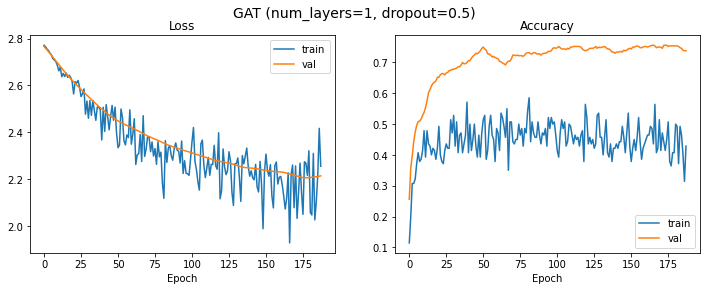

In [19]:
NUM_LAYERS = 1
DROPOUT = 0.5


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dropout=DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, dropout={DROPOUT})")

## Activation (Non-linearity)


Epoch: 0
----------
Train loss: 3.2581 | Train acc: 0.0571
  Val loss: 2.7696 |   Val acc: 0.1780

Epoch: 20
----------
Train loss: 1.7091 | Train acc: 0.4786
  Val loss: 2.6573 |   Val acc: 0.6960

Epoch: 40
----------
Train loss: 1.4276 | Train acc: 0.5643
  Val loss: 2.4427 |   Val acc: 0.6740

Epoch: 60
----------
Train loss: 1.4781 | Train acc: 0.5143
  Val loss: 2.1331 |   Val acc: 0.6500

Epoch: 80
----------
Train loss: 1.5767 | Train acc: 0.5143
  Val loss: 1.8168 |   Val acc: 0.6220

Epoch: 100
----------
Train loss: 1.3195 | Train acc: 0.6286
  Val loss: 1.7445 |   Val acc: 0.6200

Early stopping...

Epoch: 120
----------
Train loss: 1.4683 | Train acc: 0.5929
  Val loss: 1.7602 |   Val acc: 0.5940
 Test loss: 1.6978 |  Test acc: 0.6250


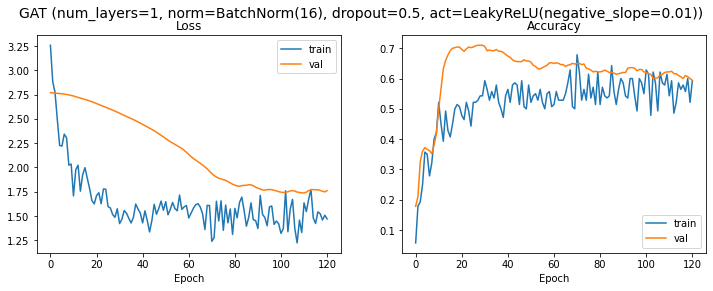

In [20]:
NUM_LAYERS = 1
NORM = BatchNorm(HIDDEN_CHANNELS)
DROPOUT = 0.5
ACT = torch.nn.LeakyReLU()


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, norm=NORM, dropout=DROPOUT, act=ACT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, norm={NORM}, dropout={DROPOUT}, act={ACT})")

# Stacking GNN Layers


Epoch: 0
----------
Train loss: 2.7726 | Train acc: 0.0571
  Val loss: 2.7625 |   Val acc: 0.1640

Epoch: 20
----------
Train loss: 2.4210 | Train acc: 0.1429
  Val loss: 2.3746 |   Val acc: 0.1620

Epoch: 40
----------
Train loss: 2.1854 | Train acc: 0.6857
  Val loss: 2.1046 |   Val acc: 0.5580

Epoch: 60
----------
Train loss: 1.8851 | Train acc: 0.6714
  Val loss: 1.8926 |   Val acc: 0.5940

Epoch: 80
----------
Train loss: 1.4630 | Train acc: 0.6857
  Val loss: 1.6024 |   Val acc: 0.6380

Epoch: 100
----------
Train loss: 1.1790 | Train acc: 0.7071
  Val loss: 1.4921 |   Val acc: 0.5760

Early stopping...

Epoch: 117
----------
Train loss: 1.0511 | Train acc: 0.7143
  Val loss: 1.4722 |   Val acc: 0.5760
 Test loss: 1.4984 |  Test acc: 0.5940


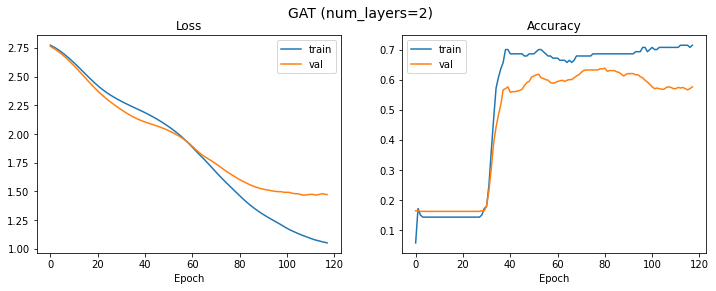

In [21]:
NUM_LAYERS = 2


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS})")

# Expressive Power for Shallow GNNs

In [22]:
class PrePostProc(torch.nn.Module):
    def __init__(
        self,
        model: torch.nn.Module,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_classes: int,
        num_pre_layers: int = 0,
        num_post_layers: int = 0,
        act: Callable[[Tensor], Tensor] = torch.nn.ReLU(inplace=True),
    ) -> None:
        super().__init__()

        self.model = model
        preproc = []
        postproc = []
        if num_pre_layers:
            preproc.append(torch.nn.Linear(in_channels, hidden_channels))
            preproc.append(act)

        for idx in range(num_pre_layers - 1):
            preproc.append(torch.nn.Linear(hidden_channels, hidden_channels))
            preproc.append(act)

        for idx in range(num_post_layers - 1):
            postproc.append(torch.nn.Linear(out_channels, out_channels))
            postproc.append(act)

        if num_post_layers:
            postproc.append(torch.nn.Linear(out_channels, num_classes))

        self.preproc = torch.nn.Sequential(*preproc)
        self.postproc = torch.nn.Sequential(*postproc)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.preproc(x)
        x = self.model(x, edge_index)
        x = self.postproc(x)
        return x


Epoch: 0
----------
Train loss: 1.9583 | Train acc: 0.1429
  Val loss: 1.9493 |   Val acc: 0.1140

Epoch: 20
----------
Train loss: 1.9433 | Train acc: 0.1429
  Val loss: 1.9383 |   Val acc: 0.1560

Epoch: 40
----------
Train loss: 1.3726 | Train acc: 0.2929
  Val loss: 1.6333 |   Val acc: 0.2520

Early stopping...

Epoch: 48
----------
Train loss: 1.1413 | Train acc: 0.4857
  Val loss: 2.0106 |   Val acc: 0.3720
 Test loss: 1.9923 |  Test acc: 0.3660


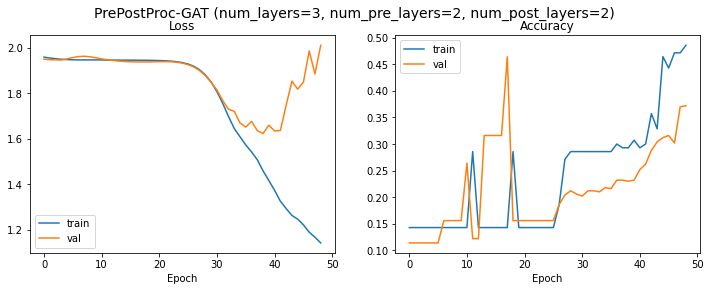

In [23]:
NUM_LAYERS = 3
NUM_PRE_LAYERS = 2
NUM_POST_LAYERS = 2

model = PrePostProc(
    model=GAT(HIDDEN_CHANNELS, HIDDEN_CHANNELS, NUM_LAYERS, out_channels=HIDDEN_CHANNELS),
    in_channels=dataset.num_node_features,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=HIDDEN_CHANNELS,
    num_classes=dataset.num_classes,
    num_pre_layers=NUM_PRE_LAYERS,
    num_post_layers=NUM_POST_LAYERS,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(
    history,
    f"PrePostProc-GAT (num_layers={NUM_LAYERS}, num_pre_layers={NUM_PRE_LAYERS}, num_post_layers={NUM_POST_LAYERS})",
)

# Design GNN Layer Connectivity

In [24]:
from torch_geometric.nn import GCNConv

In [25]:
class GCNConvBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
        add_skip: bool = False,
    ) -> None:
        super().__init__()
        self.conv = GCNConv(in_channels, in_channels, normalize=normalize)
        self.norm = copy.deepcopy(norm)
        self.act = act
        self.add_skip = add_skip

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        out = self.conv(x, edge_index)
        if self.norm is not None:
            out = self.norm(out)

        if self.add_skip:
            out += x

        if self.act is not None:
            out = self.act(out)

        return out

# Example: GCN with Skip Connections

In [26]:
class GCNSkip1(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        out_channels: int,
        dropout: float = 0.0,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
    ):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
        skip_blocks = []
        for _ in range(num_layers):
            skip_blocks.append(
                (
                    GCNConvBlock(hidden_channels, act=act, norm=norm, normalize=normalize, add_skip=True),
                    "x, edge_index -> x",
                )
            )

        self.skip_blocks = Sequential("x, edge_index", modules=skip_blocks)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.linear1(x)
        x = self.skip_blocks(x, edge_index)
        x = self.linear2(x)
        return x


Epoch: 0
----------
Train loss: 1.9572 | Train acc: 0.1357
  Val loss: 1.9614 |   Val acc: 0.1260

Epoch: 20
----------
Train loss: 1.2202 | Train acc: 0.4500
  Val loss: 1.5230 |   Val acc: 0.3860

Early stopping...

Epoch: 35
----------
Train loss: 0.2947 | Train acc: 0.9714
  Val loss: 1.6625 |   Val acc: 0.5780
 Test loss: 1.5493 |  Test acc: 0.5950


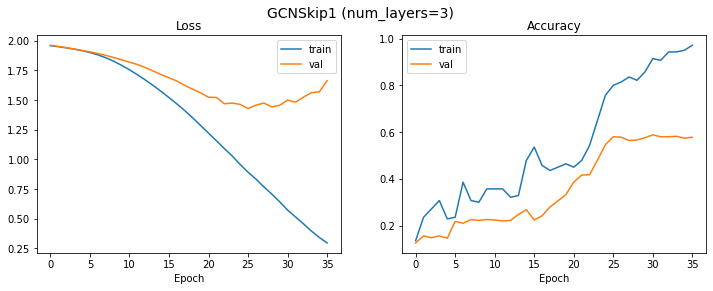

In [27]:
NUM_LAYERS = 3


model = GCNSkip1(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCNSkip1 (num_layers={NUM_LAYERS})")

# Other Option of Skip Connections

In [28]:
class GCNSkip2(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        out_channels: int,
        dropout: float = 0.0,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append((GCNConvBlock(hidden_channels, act=act, norm=norm, normalize=normalize)))

        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.linear1(x)
        outs = [x]
        for idx in range(self.num_layers):
            outs.append(self.convs[idx](outs[-1], edge_index))

        x = torch.mean(torch.stack(outs), axis=0)
        x = self.linear2(x)
        return x


Epoch: 0
----------
Train loss: 1.9523 | Train acc: 0.1429
  Val loss: 1.9398 |   Val acc: 0.1620

Epoch: 20
----------
Train loss: 1.7352 | Train acc: 0.5214
  Val loss: 1.8389 |   Val acc: 0.3320

Epoch: 40
----------
Train loss: 0.8064 | Train acc: 0.8500
  Val loss: 1.3074 |   Val acc: 0.6000

Early stopping...

Epoch: 57
----------
Train loss: 0.1693 | Train acc: 0.9929
  Val loss: 1.3507 |   Val acc: 0.6680
 Test loss: 1.2927 |  Test acc: 0.6520


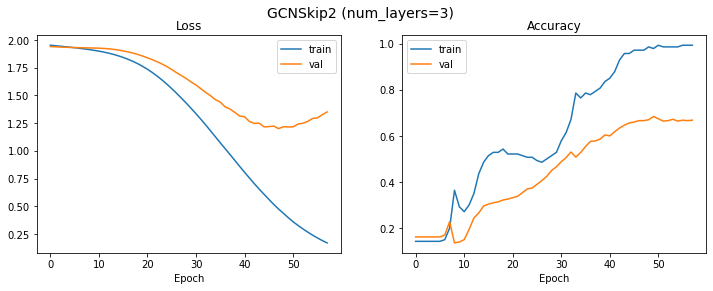

In [29]:
NUM_LAYERS = 3


model = GCNSkip2(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCNSkip2 (num_layers={NUM_LAYERS})")